# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [1]:
# %%capture --no-stderr
# %pip install --quiet -U langchain_openai langchain_core langgraph
# !pip install langchain_ollama

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

This follows what we did previously.

In [4]:
from langchain_ollama import ChatOllama

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: float, b: float) -> float:
    """Subtracts b from a.

    Args:
        a: first number
        b: second number
    """
    return a - b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, subtract, multiply, divide]
llm = ChatOllama(model='llama3.1')
llm_with_tools = llm.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a simple calculator. Respond with only the final numerical result.")

# Node
def calculator(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


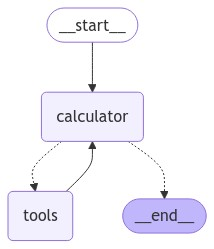

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes
builder.add_node("calculator", calculator)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "calculator")
builder.add_conditional_edges(
    "calculator",
    tools_condition,
)
builder.add_edge("tools", "calculator")
calculator_graph = builder.compile()

# Show
display(Image(calculator_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [7]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = calculator_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (f8a3ca29-899d-44c9-a92d-a2085230ba1d)
 Call ID: f8a3ca29-899d-44c9-a92d-a2085230ba1d
  Args:
    a: 3
    b: 4
  multiply (f65903c7-c21e-4569-9a27-1936518dfb1e)
 Call ID: f65903c7-c21e-4569-9a27-1936518dfb1e
  Args:
    a: 7
    b: 2
  divide (b26eb9b4-5f8b-4832-80d6-4a3db1f10295)
 Call ID: b26eb9b4-5f8b-4832-80d6-4a3db1f10295
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
================================= Tool Message =================================
Name: divide

2.8
================================== Ai Message ==================================
Tool Calls:
  divide (c482

In [8]:
messages = [HumanMessage(content="Multiply that by 3.")]
messages = calculator_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (801a5024-1639-4b59-802d-89e5906eb2df)
 Call ID: 801a5024-1639-4b59-802d-89e5906eb2df
  Args:
    a: 1
    b: 3
================================= Tool Message =================================
Name: multiply

3
================================== Ai Message ==================================

3 * 3 = 9


We don't retain memory of 2.8 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
calculator_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [10]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = calculator_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (2685f255-1d3e-4605-8c8f-ec45a2cf1554)
 Call ID: 2685f255-1d3e-4605-8c8f-ec45a2cf1554
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The final answer is $\boxed{7}$.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [11]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = calculator_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (2685f255-1d3e-4605-8c8f-ec45a2cf1554)
 Call ID: 2685f255-1d3e-4605-8c8f-ec45a2cf1554
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The final answer is $\boxed{7}$.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (2dab9e9a-ed4b-4ece-8188-9009cf4a6fcf)
 Call ID: 2dab9e9a-ed4b-4ece-8188-9009cf4a6fcf
  Args:
    a: x
    b: 2
================================= Tool Message =================================
Name: multiply

Error: 1 validation error for multiply
a
  Input should be a valid int